# **TweetsText Mining Classification XLNet Cyberbulling**

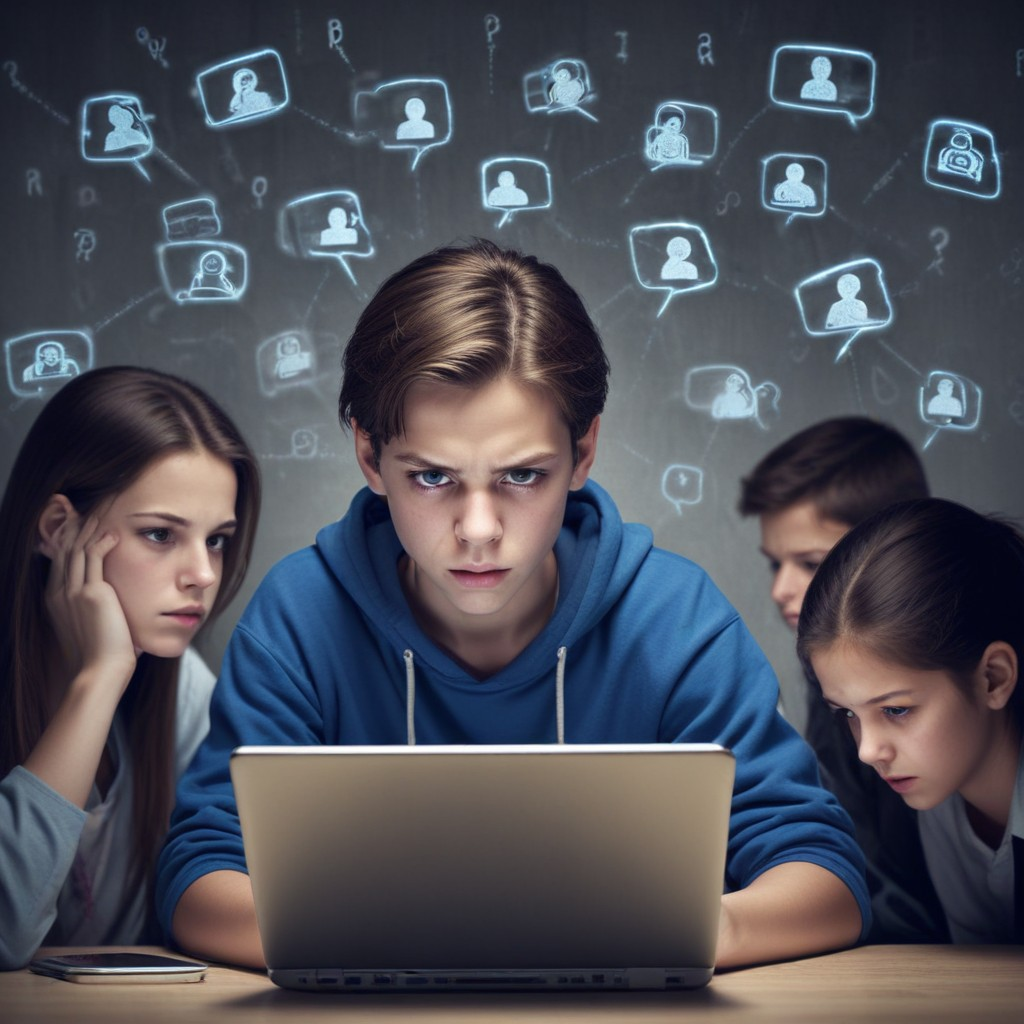

In [ ]:
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate
!pip install accelerate --upgrade

  Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
  Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 

In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# **Proyecto**


En este Proyecto vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Entrenaremos un modelo de clasificación utilizando la librería Transformers.Obviamos el análisis exploratorio ya que ha sido realizado en el proyecto anterior.

## 🤗 HuggingFace Transformers

HuggingFace está construido sobre el objeto ``pipeline()``. Esta función permite abstraerse de la complejidad del código y focalizar los esfuerzos en la atarea que se quiere conseguir realizar.

Pipeline permite, entre otras cosas, cargar pipeline pre-entrenada para diferentes tareas como análisis de sentimiento, text-generation o traducción de forma muy sencilla.

En primer lugar se cargaría el módulo

In [ ]:
from transformers import pipeline



*   Análisis de sentimiento



In [ ]:
sent_class = pipeline("sentiment-analysis")
sent_class("I hate that rythm, but I love the guitar sound")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.999613344669342}]

*   Generación de texto


In [ ]:
gen_text = pipeline("text-generation", model="distilgpt2")
gen_text("I hate that rythm, but", max_length=50)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'I hate that rythm, but I\'m not an adult person.\n"Don\'t worry about us, what we do," says Giorgio Cifraire.\nBarely two months at his feet, it seems like his biggest'}]

# Fine-tuning de modelo de lenguaje para clasificación:

Cuando se entrena un modelo de lenguaje utilizando una arquitectura de tipo Transformers se utilizan grandes cantidades de textos para que la red neuronal aprenda patrones, relaciones y estructuras de un idioma. El resultado de este proceso se conoce como *modelo pre-entrenado*, que esencialmente es una red neuronal que ha capturado el concimiento general del idioma, permitiendo predecir palabras con eficacia, pero sin capacidades de llevar a cabo tareas específicas como la clasificación de textos.

El poder de los modelos pre-entrenados radica en su capacidad para ser ajustados o *afinados* y resolver una tarea específica como traducción automática, resumen de textos, extracción de información o **clasificación de textos**. Este proceso de ajuste se conoce como *fine-tuning*, y cuando se aplica se aprovecha el conocimiento adquirido por el modelo de lenguaje en el pre-entrenamiento para resolver el problema en cuestión.

Cuando llevamos a cabo el ajuste de un modelo pre-entrenado para resolver un problema de clasificación se incorpora una *classification head* que utiliza las representaciones vectoriales generadas por el modelo de lenguaje para crear predicciones específicas de las categorías que queremos predecir asociadas al texto, previo proceso de enseñar a esa capa a llevar a cabo la clasificación de forma efectiva. Cuando se utiliza la librería *Transformers* esta capa de clasificación es una red neuronal simple, pero podría utilizarse cualquier otra estructura como un regresor logístico.


## 0. Imports


In [ ]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import imblearn
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import pandas as pd

# Introducción

- En este cuaderno, exploramos las capacidades avanzadas de XLNet, un modelo de lenguaje de vanguardia, en el contexto de la detección y clasificación del ciberacoso. XLNet, desarrollado por investigadores de Google y la Universidad Carnegie Mellon, es un modelo de preentrenamiento autorregresivo generalizado.

- A diferencia de los modelos BERT tradicionales, XLNet captura el contexto bidireccional mediante el uso de un enfoque de entrenamiento basado en permutaciones. Este método permite que el modelo aprenda el contexto de una palabra basándose en todas las permutaciones de las palabras en una oración, ofreciendo así una comprensión más profunda de la semántica del lenguaje.

### Objetivo

- El objetivo principal es ajustar XLNet para la tarea de clasificar texto en dos categorías de ciberacoso. Las categorías consideradas en este estudio son "ciberacoso", "no_ciberacoso".
Estas categorías cubren un amplio espectro de incidentes de ciberacoso, lo que nos permite desarrollar un modelo robusto que se puede utilizar de manera efectiva en diversos entornos en línea.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
data = load_prepare_data(path_data)

In [ ]:
data.head()

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


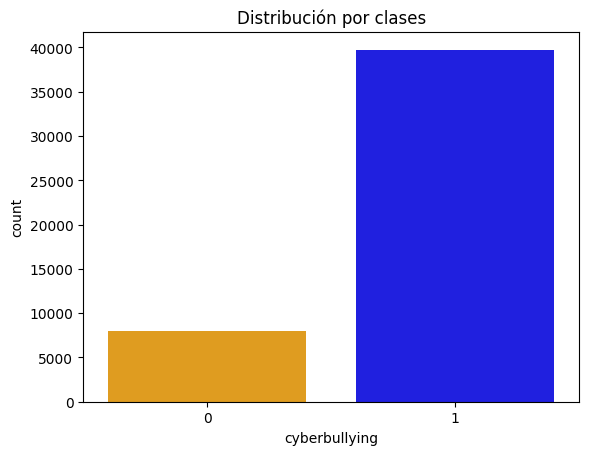

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar los datos y calcular el conteo
data_grouped = data.groupby('cyberbullying').size().reset_index(name='count')

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear el gráfico de barras
sns.barplot(x='cyberbullying', y='count', data=data_grouped, palette=['orange', 'blue'], ax=ax)

# Configurar el título y mostrar el gráfico
ax.set_title('Distribución por clases')
plt.show()



Como se puede observar existe desbalanceo de clases, lo cual solucionaremos más adelante.


In [ ]:
import plotly.express as px

# Definimos la secuencia de colores
color_discrete_sequence = ['orange', 'blue']

# Creamos el boxplot
fig = px.box(data,
             x='cyberbullying',
             y=data['tweet_text'].apply(lambda x: len(x.split())),  # Calculamos la longitud de los tweets aquí
             color='cyberbullying',
             color_discrete_sequence=color_discrete_sequence,
             template='plotly',
             title='Boxplot de Longitudes de Tweets por clase')

# Ajustamos el rango del eje y
fig.update_yaxes(range=[0, 100])

# Mostramos el gráfico
fig.show()



También se observan outliers en la cateroría 1, por encima de 70 palablras por tweet.

### Cleaning the Dataset

In [ ]:
# Número de tweets en cada categoría con menos de diez palabras
tweets_c0 = 53
tweets_c1 = 151

# Número total de tweets
total_tweets = 47692

# Calcula los porcentajes
porcentaje_cat0 = (tweets_c0 / total_tweets) * 100
porcentaje_cat1 = (tweets_c1 / total_tweets) * 100

# Imprime los resultados
# Imprime los resultados con el símbolo %
print("Porcentaje de tweets con menos de 10 palabras en la categoría 0: %.2f%%" % porcentaje_cat0)
print("Porcentaje de tweets con menos de 10 palabras en la categoría 1: %.2f%%" % porcentaje_cat1)


Porcentaje de tweets con menos de 10 palabras en la categoría 0: 0.11%
Porcentaje de tweets con menos de 10 palabras en la categoría 1: 0.32%


Posteriormente podremos filtrar los tokens o subtokens en el Procesado

In [ ]:
cantidad_duplicados = np.sum(data.duplicated(subset=["tweet_text"]))

if cantidad_duplicados > 0:
    print("Existen {} documentos duplicados".format(cantidad_duplicados))
    # Quitaremos esos duplicados
    dataset = data.drop_duplicates(subset=["tweet_text"])
    print("Después de quitar duplicados, tenemos un conjunto de {} documentos".format(dataset.shape[0]))
else:
    print("No hay documentos duplicados en el conjunto de datos.")

Existen 1675 documentos duplicados
Después de quitar duplicados, tenemos un conjunto de 46017 documentos


Ahora procederemos a renombrar las variables, para mayor facilidad al escribir el código.

In [ ]:
texts = data.tweet_text.values  # an array of strings
labels = data.cyberbullying.values  # an array of integers

Despues dividimos el conjunto de datos en Train-Validation (80%) y Test(10%)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Crear el sobremuestreador
ros = RandomOverSampler(random_state=42)

# Aplicar el sobremuestreo a los datos de entrenamiento
train_texts_res, train_labels_res = ros.fit_resample([[t] for t in train_texts], train_labels)

# Aplanar la lista de listas resultante
train_texts_res = [item for sublist in train_texts_res for item in sublist]

# Dividir los datos de entrenamiento en conjuntos de entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts_res, train_labels_res, test_size=.2, random_state=0, stratify=train_labels_res)


In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch

In [ ]:
model_name = 'xlnet-base-cased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
texto = "feminazy"
texto_tokens = tokenizer(texto).tokens()
texto_tokens

['▁fe', 'mina', 'zy', '<sep>', '<cls>']

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Devolver el diccionario con los datos
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


In [ ]:
max_length = 128  # Puedes ajustar esto según tus necesidades

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)


Podremos ver que cada elemento del nuevo formato tendrá:
- *inputs_ids*: Identificadores numéricos de los tokens en el vocabulario del modelo
- *attention_mask*: Vector que indica a la red neuronal qué partes de la secuencia de entrada debe prestar atención y cuáles ignorar.
- *labels*: Este campo contiene la etiqueta asociada al texto

In [ ]:
train_dataset[10]

{'input_ids': tensor([    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,    35,
          9131,   919,   712,  1507,  9465,    24,  1081,    20, 18258,   787,
         12558,    17,  7967,   692,   

Antes de preprocesar la entrada, necesitamos definir la longitud de la secuencia (longitud maxima del documento en tokens) y el Batch size. En Colab, hay limitaciones (batch = 8 y secuencia=96). Si se reduciera el batch se podría incrementar el tamaño, pero en este caso nos es indiferente.

### Entrenamiento

Para llevar a cabo el entrenamiento tenemos que cargar el modelo en el entorno de ejecución. Para ello utilizaremos la clase `AutoModelForSequenceClassification()`, que permite cargar modelos  que van a ser ajustados para clasificar secuencias de textos.

Dentro de esta clase especificaremos el número de etiquetas que tenemos en nuestro problema de clasificación (en este caso 2), e introduciremos unos diccionarios para gestionar y entender mejor la salida del modelo.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NO_CYBERBULLYING", 1: "CYBERBULLYING"}
label2id = {"NO_CYBEBULLYIN": 0, "CYBERBULLYING": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=2, id2label=id2label, label2id=label2id)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

In [ ]:
from transformers import TrainingArguments
import accelerate

training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#### Evaluación

Una vez entrenado el modelo, llevaremos a cabo su evaluación.

El objeto `Trainer()` tiene un método `.evaluate()` que permite introducir un conjunto de datos de evaluación y obtener las métricas accuracy y f1 definidas previamente.

In [ ]:
# Número de épocas
num_epochs = 4

# Listas para almacenar los resultados
train_results = []
valid_results = []
test_results = []

# Bucle para entrenar y evaluar el modelo durante varias épocas
for epoch in range(num_epochs):
    print(f"\nÉpoca {epoch+1}/{num_epochs}")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el modelo en el conjunto de entrenamiento
    train_result = trainer.evaluate(train_dataset)
    train_results.append(train_result)

    # Evaluar el modelo en el conjunto de validación
    val_result = trainer.evaluate(val_dataset)
    valid_results.append(val_result)

    # Evaluar el modelo en el conjunto de prueba
    test_result = trainer.evaluate(test_dataset)
    test_results.append(test_result)

# Convertir los resultados de la evaluación en DataFrames
import pandas as pd
train_df = pd.DataFrame(train_results)
valid_df = pd.DataFrame(valid_results)
test_df = pd.DataFrame(test_results)

# Mostrar los DataFrames
print("\nResultados de entrenamiento:")
print(train_df)
print("\nResultados de validación:")
print(valid_df)
print("\nResultados de prueba:")
print(test_df)



Época 1/4


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.107000,0.251339,{'accuracy': 0.9470870351442724},{'f1': 0.944804395964898}


Trainer is attempting to log a value of "{'accuracy': 0.9470870351442724}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.944804395964898}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "{'accuracy': 0.9816216216216216}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.98133695283339}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9470870351442724}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.944804395964898}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8520809309151903}" of type <class '


Época 2/4


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.102500,0.246733,{'accuracy': 0.9481091280761066},{'f1': 0.9459105064743485}


Trainer is attempting to log a value of "{'accuracy': 0.9481091280761066}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9459105064743485}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "{'accuracy': 0.9821719901719902}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9818900624962561}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9481091280761066}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9459105064743485}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8526050948736765}" of type <clas


Época 3/4


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.117400,0.254796,{'accuracy': 0.949681578740467},{'f1': 0.9478742466199707}


Trainer is attempting to log a value of "{'accuracy': 0.949681578740467}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9478742466199707}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "{'accuracy': 0.9795773955773955}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9793196791465137}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.949681578740467}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9478742466199707}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8537582555823462}" of type <class


Época 4/4


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.114000,0.277879,{'accuracy': 0.9460649422124381},{'f1': 0.9437889216650278}


Trainer is attempting to log a value of "{'accuracy': 0.9460649422124381}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9437889216650278}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "{'accuracy': 0.9805208845208845}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9802365235426679}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9460649422124381}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9437889216650278}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.85323409162386}" of type <class 


Resultados de entrenamiento:
   eval_loss                     eval_accuracy               eval_f1_score  \
0   0.079835  {'accuracy': 0.9816216216216216}    {'f1': 0.98133695283339}   
1   0.075388  {'accuracy': 0.9821719901719902}  {'f1': 0.9818900624962561}   
2   0.091263  {'accuracy': 0.9795773955773955}  {'f1': 0.9793196791465137}   
3   0.086125  {'accuracy': 0.9805208845208845}  {'f1': 0.9802365235426679}   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0      162.6877                  312.716                 39.093    1.0  
1      160.7017                  316.580                 39.576    1.0  
2      160.9143                  316.162                 39.524    1.0  
3      159.0768                  319.814                 39.981    1.0  

Resultados de validación:
   eval_loss                     eval_accuracy               eval_f1_score  \
0   0.251339  {'accuracy': 0.9470870351442724}   {'f1': 0.944804395964898}   
1   0.246733  {'accuracy': 0.94

# Nueva sección

También vamos a hacer un classification report para ver los scores relativo a cada categoría. Para eso, predeciremos las etiquetas sobre el test set con el método `.predict()`. Y obtendremos la etiqueta de cada predicción.

In [ ]:
# Make predictions on the test data
predictions = trainer.predict(test_dataset)

In [ ]:
predictions

PredictionOutput(predictions=array([[-4.077235 ,  4.9082866],
       [ 3.358643 , -3.4173267],
       [-4.0839148,  4.909067 ],
       ...,
       [-4.0834503,  4.909074 ],
       [-4.0555596,  4.904065 ],
       [-4.0818543,  4.908794 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.8943614959716797, 'test_accuracy': {'accuracy': 0.85323409162386}, 'test_f1_score': {'f1': 0.9104973788518093}, 'test_runtime': 31.82, 'test_samples_per_second': 299.78, 'test_steps_per_second': 37.492})

In [ ]:
predictions[1][3]

1

In [ ]:
# Access the predicted labels
y_pred = predictions.predictions.argmax(axis=1)


Cogemos las etiquetas verdaderas y calculamos el classification report:

In [ ]:
y_true = [x["labels"].item() for x in test_dataset]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[1018  571]
 [ 829 7121]]
              precision    recall  f1-score   support

           0       0.55      0.64      0.59      1589
           1       0.93      0.90      0.91      7950

    accuracy                           0.85      9539
   macro avg       0.74      0.77      0.75      9539
weighted avg       0.86      0.85      0.86      9539




Podemos comparar los resultados con el clasificador obtenido mediante ingeniería de características:
                           precision    recall  f1-score   support

           0       0.47      0.64      0.55      1589
           1       0.92      0.86      0.89      7950

    accuracy                           0.82      9539
  

También podemos predecir cualquier frase o tweet que quisiéramos de forma sencilla:


In [ ]:
# Create a function to predict for a single document
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_single_document(document, max_length=128):
    # Tokenize the input document
    inputs = tokenizer(document, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to the same device as the model

    # Make the prediction
    with torch.no_grad():
      model_output = trainer.model(**inputs)

    # Access the predicted labels
    predicted_label = torch.argmax(model_output.logits).item()

    return predicted_label

In [ ]:
#@markdown >Escribe el texto que quieras clasificar
input_text1 = 'I hate that noise'
input_text2 = 'I feel so lucky that today is about the quietest its ever been here. Fewer copters, no construction noise. Ahhhhhhhhh #selfcare https://t.co/7Ka4M6wFQv'

pred1 = predict_single_document(input_text1)
pred2 = predict_single_document(input_text2)

# label_mapping = {0:"no molesto",1:"molesto"}

print("Clase texto 1: {}".format(pred1))
print("Clase texto 2: {}".format(pred2))

Clase texto 1: 0
Clase texto 2: 1


##Resumen
En este cuaderno hemos utilizado el fine-tuning es una práctica común con el modelo XLNet, especialmente en tareas de clasificación de texto. XLNet es un modelo de lenguaje preentrenado que utiliza un método autoregresivo generalizado para el preentrenamiento. Al realizar fine-tuning de XLNet en un conjunto de datos específico, se pueden obtener resultados que superan a los del modelo BERT en varias tareas de procesamiento de lenguaje natural (NLP)12.

El fine-tuning permite ajustar los pesos del modelo preentrenado para que se adapte mejor a las características del conjunto de datos objetivo. Esto se hace entrenando el modelo en el nuevo conjunto de datos durante algunas épocas, lo que permite que el modelo aprenda las peculiaridades del texto específico al que se aplica.

Ajustamos con  el modelo XLNet para clasificar con precisión el texto en dos diferentes categorías de ciberacoso.Para ello  hemos tenido que cambiar varias funciones para un mejor ajuste a nuestro modelo. Nuestro enfoque se extendió más allá de lograr una alta precisión; Abarcaba un profundo conocimiento de cada paso del proceso y de la funcionalidad de los componentes que utilizábamos.

# Conclusión


Rendimiento y métricas
El modelo XLNet ajustado mostró un mejor rendimiento que el modelo RamdomForest, de ingeniería de caraácterísticas, pero no demasiado.

El modelo acertó en sus predicciones independientemente de la clase, un 85% de las veces, un 3% más que el modelo anterior.

Precisión: 55%: esta  precisión indica la capacidad del modelo para identificar y categorizar correctamente los casos de ciberacoso, algo superior a la del modelo Random-Foreste que era de un 47%.

En general las métricas de este modelo mejoraron el anterior, pero no en demasía, tendríamos que seguir entrenando y ajustando parámetros para mejorarlo, si bien es cierto que los resultados no están mal, habría que mejorar la precisión del mismo.





